In [28]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import statistics as stat
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

In [2]:
label_encoder = None 

In [3]:
def get_np_array(file_name, encoding="onehot"):
    global label_encoder
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','opp','host','month', 'day_match']
#     if(label_encoder is None):
    if encoding == "ordinal":
        label_encoder = OrdinalEncoder()
    else:
        label_encoder = OneHotEncoder(sparse_output = False)
    label_encoder.fit(data[need_label_encoding])
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    return X.to_numpy(), y.to_numpy()

In [4]:
class DTNode:
    def __init__(self, depth, my_id=None, is_leaf=False, value=0, data=None, columns=None, split_feature = None, split_feature_value = None, threshold = None):
        #To uniquely identify a node
        self.my_id = my_id
        
        self.depth = depth 

        #add children afterwards
        self.children = []
        
        #if leaf
        self.is_leaf = is_leaf
        
        #It stores the majority y
        self.value = value 
        
        #Below attributes makes sense for decision nodes (non leaf nodes)
        self.split_feature = split_feature
        self.split_feature_value = split_feature_value #only makes sense for categorical attributes. ex we want to move to children with weather="sunny"
        self.threshold = threshold #only makes sense for continouos attributes

        self.columns = columns
        self.data = data

In [5]:
class DTTree:
    def __init__(self, X_train, y_train, types):
        #Tree root should be DTNode
        self.root = None 
        
        self.X_train = X_train
        self.y_train = y_train
        self.types = types
        
        self.id_counter = 0
        
        self.columns = [i for i in range(X_train.shape[1])]
        self.data = np.array([i for i in range(len(X_train))])
        
    #returns a dictionary with unique values and corresponding split
    def get_data_split(self, data, idx):
        data_split = dict()
        # print(data)
        X_temp = self.X_train[data]
        
        if self.types[idx] == 'cat':
            unique_vals = np.unique(X_temp[:,idx])
            for val in unique_vals:
                indices = np.array([i for i, value in enumerate(X_temp[:,idx] == val) if value])
                data_split[val] = data[indices]
            return data_split
                
        elif self.types[idx] == 'cont':
            median = stat.median(X_temp[:,idx])
            
            indices = np.array([i for i, value in enumerate(X_temp[:,idx] <= median) if value])
            if indices.shape[0] != 0:
                data_split["less_than_equal"] = data[indices]
                
            indices = np.array([i for i, value in enumerate(X_temp[:,idx] > median) if value])
            if indices.shape[0] != 0:
                data_split["more_than"] = data[indices]
                
            return data_split
        
    @staticmethod
    def compute_entropy(y, data):
        y_temp = y[data]
        unique_values, value_counts = np.unique(y_temp, return_counts=True)
        # print("unique values:",unique_values)
        # print("value_counts:",value_counts)
        entropy = 0
        for val in value_counts:
            p = val/value_counts.sum()
            entropy += (-1)*p*np.log2(p)
        return entropy, unique_values[0]
    
    @staticmethod
    def compute_entropy_attr(X, y, data, col, col_type=None):
        entropy = 0
        X_temp = X[data]
        y_temp = y[data]
        S = len(data)
        # print("total:",S)
        # print(col, col_type)
        if col_type == 'cat':
            unique_vals = np.unique(X_temp[:,col])
            for val in unique_vals:
                S_val = np.count_nonzero(X_temp[:,col]==val)
                entropy_temp,_ = DTTree.compute_entropy(y_temp, X_temp[:,col]==val)
                # print(val, S_val, entropy_temp)
                entropy += (S_val/S)*entropy_temp
        elif col_type == 'cont':
            median = stat.median(X_temp[:,col])
            S_val1 = np.count_nonzero(X_temp[:,col] <= median)
            S_val2 = np.count_nonzero(X_temp[:,col] > median)
            entropy_temp1,_ = DTTree.compute_entropy(y_temp, X_temp[:,col] <= median)
            entropy_temp2,_ = DTTree.compute_entropy(y_temp, X_temp[:,col] > median)
            # print(S_val1, entropy_temp1)
            # print(S_val2, entropy_temp2)
            entropy = ((S_val1/S)*entropy_temp1)+((S_val2/S)*entropy_temp2)
        return entropy
        
    def get_majority_y(self, data):
        y_temp = self.y_train[data]
        y_temp = y_temp.reshape(-1)
        return stat.mode(y_temp)
        
    def build_tree(self, this_node=None, data = None, columns = None):
        # print(data)
        entropy, y_pred = DTTree.compute_entropy(self.y_train, data)
        # print("entropy: ",entropy)
        #when entropy would be zero,only one type of y would be present, y_pred makes sense else no
        if entropy == 0:
            this_node.is_leaf = True
            this_node.value = y_pred
            
            #Updating ID
            if this_node.my_id == None:
                this_node.my_id = self.id_counter
                self.id_counter += 1
            return this_node
        else:
            if(len(columns) == 0):
                this_node.is_leaf = True
                this_node.value = self.get_majority_y(data)
                
                #Updating ID
                if this_node.my_id == None:
                    this_node.my_id = self.id_counter
                    self.id_counter += 1
                return this_node
            #Splitting criteria
            entropy_cols = np.zeros(len(columns))
            IG_cols = np.zeros(len(columns))
            for i in range(len(columns)):
                entropy_cols[i] = DTTree.compute_entropy_attr(self.X_train, self.y_train, self.data, columns[i], self.types[columns[i]])
                IG_cols[i] = entropy - entropy_cols[i]
                # print(columns[i],IG_cols[i])
            #creating a node and returning
            idx = columns[np.argmax(IG_cols)]
            
            this_node.is_leaf = False
            this_node.split_feature = idx
            this_node.value = self.get_majority_y(data)
            this_node.columns = columns
            this_node.data = data
            
            data_split = DTTree.get_data_split(self, data, idx)
            
            if self.types[idx] == 'cat':
                # print(f"BUILD cat idx={idx}")
                for key,val in data_split.items():
                    new_columns = columns.copy()
                    
                    new_columns.remove(idx)
                    
                    child_node = DTNode(depth = this_node.depth + 1, my_id = self.id_counter, is_leaf=False, split_feature_value=key)
                    self.id_counter += 1
                    this_node.children.append(self.build_tree(child_node, data=val, columns=new_columns))
            elif self.types[idx] == 'cont':
                # print(f"BUILD cont idx={idx}")
                if len(data_split) > 1:
                    for key,val in data_split.items():
                        X_temp = self.X_train[data]
                        this_node.threshold = stat.median(X_temp[:,idx])
                        child_node = DTNode(depth = this_node.depth + 1, my_id = self.id_counter, is_leaf=False, split_feature_value=key)
                        self.id_counter += 1
                        this_node.children.append(self.build_tree(child_node, data=val, columns=columns))
                else:
                    new_columns = columns.copy()
                    
                    new_columns.remove(idx)
                    
                    for key,val in data_split.items():
                        X_temp = self.X_train[data]
                        this_node.threshold = stat.median(X_temp[:,idx])
                        child_node = DTNode(depth = this_node.depth + 1, my_id = self.id_counter, is_leaf=False, split_feature_value=key)
                        self.id_counter += 1
                        this_node.children.append(self.build_tree(child_node, data=val, columns=new_columns))
                    
            return this_node
            # print("Attribute to split: ", columns[idx])
            
    @staticmethod
    def print_node(root):
        if root.is_leaf:
            print(f"I am leaf and my value is {root.value} and my depth is {root.depth}")
        else:
            # print(f"I am not a leaf and i have {len(root.children)} and my value is {root.value} and my depth is {root.depth}")
            for child in root.children:
                # print(f"parent info:: split feature: {root.split_feature}, split feature value: {root.split_feature_value}, threshold: {root.threshold}")
                # print(f"split feature: {child.split_feature}, split feature value: {child.split_feature_value}, threshold: {child.threshold}")
                DTTree.print_node(child)        
    
    def print_tree(self):
        DTTree.print_node(self.root)
        
    def predict(self, X_test, max_depth):
        y_test_pred = np.zeros((len(X_test),1))
        for index in range(len(X_test)):
            x = X_test[index]
            temp = self.root
            pred = None
            while(True):
                #Terminating condition
                if temp.is_leaf == True or temp.depth >= max_depth:
                    pred = temp.value
                    break

                split_feature = temp.split_feature
                type_split_feature = self.types[split_feature]

                if type_split_feature == "cat":
                    z = x[split_feature]
                else:
                    if x[split_feature] <= temp.threshold:
                        z = "less_than_equal"
                    else:
                        z = "more_than"

                flag = 0

                for child in temp.children:
                    if child.split_feature_value == z:
                        temp = child
                        flag = 1

                #z not found in children, so return the prediction
                if flag == 0:
                    pred = temp.value
                    break

            y_test_pred[index][0] = pred
            
        return y_test_pred
            
    def execute(self):
        this_node = DTNode(depth=0, my_id=0, is_leaf=False)
        self.id_counter += 1
        self.root = self.build_tree(this_node = this_node, data = self.data, columns = self.columns)
        print("Decision tree built successfully!")

#### Decision tree with both categorical attributes as well as continuous attributes (ordinal encoding)

In [6]:
X_train,y_train = get_np_array('../Data/train.csv', encoding="ordinal")
X_test, y_test = get_np_array("../Data/test.csv", encoding="ordinal")
X_val, y_val = get_np_array("../Data/val.csv", encoding="ordinal")

types = ['cat','cat','cat',"cat","cat","cont","cat","cat","cat" ,"cont","cont" ,"cont" ]


In [7]:
dtree = DTTree(X_train,y_train, types)
dtree.execute()

Decision tree built successfully!


In [8]:
dtree.print_tree()

I am leaf and my value is 0 and my depth is 3
I am leaf and my value is 0 and my depth is 9
I am leaf and my value is 1 and my depth is 9
I am leaf and my value is 1 and my depth is 5
I am leaf and my value is 0 and my depth is 9
I am leaf and my value is 1 and my depth is 9
I am leaf and my value is 0 and my depth is 5
I am leaf and my value is 0 and my depth is 8
I am leaf and my value is 1 and my depth is 8
I am leaf and my value is 0 and my depth is 5
I am leaf and my value is 1 and my depth is 9
I am leaf and my value is 0 and my depth is 9
I am leaf and my value is 0 and my depth is 8
I am leaf and my value is 1 and my depth is 8
I am leaf and my value is 1 and my depth is 3
I am leaf and my value is 0 and my depth is 3
I am leaf and my value is 1 and my depth is 5
I am leaf and my value is 0 and my depth is 5
I am leaf and my value is 1 and my depth is 4
I am leaf and my value is 1 and my depth is 3
I am leaf and my value is 1 and my depth is 3
I am leaf and my value is 1 and my

I am leaf and my value is 1 and my depth is 3
I am leaf and my value is 0 and my depth is 3
I am leaf and my value is 1 and my depth is 3
I am leaf and my value is 1 and my depth is 5
I am leaf and my value is 0 and my depth is 8
I am leaf and my value is 1 and my depth is 8
I am leaf and my value is 1 and my depth is 7
I am leaf and my value is 1 and my depth is 5
I am leaf and my value is 1 and my depth is 8
I am leaf and my value is 0 and my depth is 8
I am leaf and my value is 1 and my depth is 6
I am leaf and my value is 1 and my depth is 5
I am leaf and my value is 1 and my depth is 5
I am leaf and my value is 0 and my depth is 5
I am leaf and my value is 1 and my depth is 9
I am leaf and my value is 0 and my depth is 9
I am leaf and my value is 1 and my depth is 6
I am leaf and my value is 1 and my depth is 7
I am leaf and my value is 0 and my depth is 7
I am leaf and my value is 1 and my depth is 5
I am leaf and my value is 1 and my depth is 11
I am leaf and my value is 0 and m

In [9]:
max_depth_list = [5,10,15,20,25]
training_acc = []
testing_acc = []

for max_depth in max_depth_list:
    print("Max depth: ", max_depth)
    
    y_train_pred = dtree.predict(X_train, max_depth = max_depth)
    train_acc = accuracy_score(y_train, y_train_pred)
    print("training accuracy: ",train_acc)
    training_acc.append(train_acc)

    y_test_pred = dtree.predict(X_test, max_depth = max_depth)
    test_acc = accuracy_score(y_test, y_test_pred)
    print("testing accuracy: ",test_acc)
    testing_acc.append(test_acc)
    
    print("\n")

Max depth:  5
training accuracy:  0.8058004343937651
testing accuracy:  0.5842812823164426


Max depth:  10
training accuracy:  0.9753417656828925
testing accuracy:  0.5966907962771458


Max depth:  15
training accuracy:  0.9998722371278906
testing accuracy:  0.59358841778697


Max depth:  20
training accuracy:  0.9998722371278906
testing accuracy:  0.59358841778697


Max depth:  25
training accuracy:  0.9998722371278906
testing accuracy:  0.59358841778697




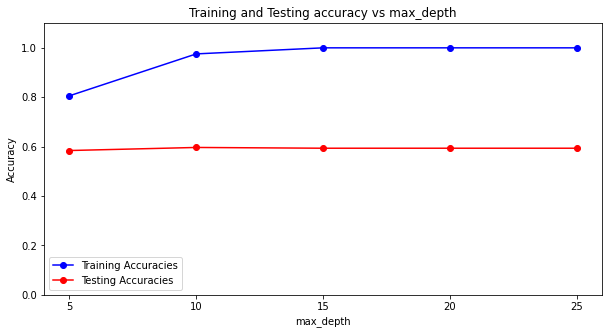

In [10]:
#Plot training and testing accuracies for different max_depth
plt.figure(figsize=(10,5))
plt.plot(max_depth_list, training_acc, marker='o', markersize=6, color='blue', label='Training Accuracies')
plt.plot(max_depth_list, testing_acc, marker='o', markersize=6, color='red', label='Testing Accuracies')

plt.title('Training and Testing accuracy vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.xticks(max_depth_list)
plt.ylim(0,1.1)
plt.legend()
plt.show()

##### Only win prediction on test data

In [11]:
y_test_pred = np.ones((len(X_test),1))
print("[ONLY WIN]testing accuracy: ",accuracy_score(y_test, y_test_pred))

[ONLY WIN]testing accuracy:  0.4963805584281282


##### Only loss prediction on test data

In [12]:
y_test_pred = np.zeros((len(X_test),1))
print("[ONLY LOSS]testing accuracy: ",accuracy_score(y_test, y_test_pred))

[ONLY LOSS]testing accuracy:  0.5036194415718718


#### Decision tree with only categorical attributes (one-hot encoding)

In [7]:
X_train,y_train = get_np_array('../Data/train.csv', encoding="onehot")
X_test, y_test = get_np_array("../Data/test.csv", encoding="onehot")
X_val, y_val = get_np_array("../Data/val.csv", encoding="onehot")

In [8]:
types = ['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cont', 'cat', 'cat', 'cat', 'cont', 'cont', 'cont']

In [9]:
# dtree_1h = DTTree(X_train,y_train, types)
# dtree_1h.execute()

In [45]:
import pickle

# file = open('dtree_1h.obj','wb')
# pickle.dump(dtree_1h,file)
# file.close()

In [46]:
rfile = open('dtree_1h.obj','rb')
dtree_1h = pickle.load(rfile)
rfile.close()
print("Decision tree loaded!")

Decision tree loaded!


In [12]:
dtree_1h.print_tree()

I am leaf and my value is 0 and my depth is 63
I am leaf and my value is 1 and my depth is 63
I am leaf and my value is 1 and my depth is 50
I am leaf and my value is 0 and my depth is 64
I am leaf and my value is 1 and my depth is 64
I am leaf and my value is 0 and my depth is 53
I am leaf and my value is 1 and my depth is 63
I am leaf and my value is 0 and my depth is 63
I am leaf and my value is 1 and my depth is 41
I am leaf and my value is 0 and my depth is 54
I am leaf and my value is 1 and my depth is 54
I am leaf and my value is 1 and my depth is 65
I am leaf and my value is 0 and my depth is 65
I am leaf and my value is 0 and my depth is 58
I am leaf and my value is 1 and my depth is 65
I am leaf and my value is 0 and my depth is 65
I am leaf and my value is 1 and my depth is 54
I am leaf and my value is 1 and my depth is 66
I am leaf and my value is 0 and my depth is 66
I am leaf and my value is 0 and my depth is 65
I am leaf and my value is 1 and my depth is 56
I am leaf and

I am leaf and my value is 0 and my depth is 53
I am leaf and my value is 1 and my depth is 56
I am leaf and my value is 0 and my depth is 56
I am leaf and my value is 1 and my depth is 57
I am leaf and my value is 0 and my depth is 57
I am leaf and my value is 1 and my depth is 57
I am leaf and my value is 0 and my depth is 57
I am leaf and my value is 1 and my depth is 56
I am leaf and my value is 0 and my depth is 56
I am leaf and my value is 1 and my depth is 68
I am leaf and my value is 0 and my depth is 70
I am leaf and my value is 1 and my depth is 70
I am leaf and my value is 1 and my depth is 55
I am leaf and my value is 0 and my depth is 56
I am leaf and my value is 1 and my depth is 56
I am leaf and my value is 1 and my depth is 54
I am leaf and my value is 1 and my depth is 46
I am leaf and my value is 0 and my depth is 44
I am leaf and my value is 1 and my depth is 63
I am leaf and my value is 0 and my depth is 63
I am leaf and my value is 1 and my depth is 56
I am leaf and

In [13]:
# for idx in range(dtree_1h.X_train.shape[1]):
#     unique_vals = np.unique(dtree_1h.X_train[:,idx])
#     print(idx, len(unique_vals))

In [14]:
max_depth_list = [15,25,35,45,55,65,75]
training_acc = []
testing_acc = []

for max_depth in max_depth_list:
    print("Max depth: ", max_depth)
    
    y_train_pred = dtree_1h.predict(X_train, max_depth = max_depth)
    train_acc = accuracy_score(y_train, y_train_pred)
    print("training accuracy: ",train_acc)
    training_acc.append(train_acc)

    y_test_pred = dtree_1h.predict(X_test, max_depth = max_depth)
    test_acc = accuracy_score(y_test, y_test_pred)
    print("testing accuracy: ",test_acc)
    testing_acc.append(test_acc)
    
    print("\n")

Max depth:  15
training accuracy:  0.5935863038201099
testing accuracy:  0.5594622543950362


Max depth:  25
training accuracy:  0.6211830841957328
testing accuracy:  0.5791106514994829


Max depth:  35
training accuracy:  0.6443081640475278
testing accuracy:  0.5811789038262668


Max depth:  45
training accuracy:  0.7093394659511946
testing accuracy:  0.5966907962771458


Max depth:  55
training accuracy:  0.8652101699246199
testing accuracy:  0.6018614270941055


Max depth:  65
training accuracy:  0.9630765299603935
testing accuracy:  0.5956566701137539


Max depth:  75
training accuracy:  1.0
testing accuracy:  0.6008273009307136




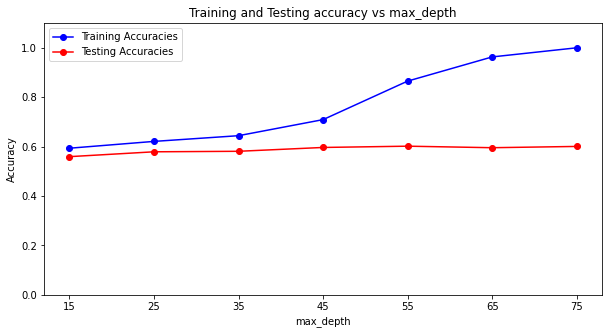

In [15]:
#Plot training and testing accuracies for different max_depth
plt.figure(figsize=(10,5))
plt.plot(max_depth_list, training_acc, marker='o', markersize=6, color='blue', label='Training Accuracies')
plt.plot(max_depth_list, testing_acc, marker='o', markersize=6, color='red', label='Testing Accuracies')

plt.title('Training and Testing accuracy vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.xticks(max_depth_list)
plt.ylim(0,1.1)
plt.legend()
plt.show()

In [47]:
def count_nodes(root):
    if root.is_leaf == True:
        return 1
    count = 1
    for child in root.children:
        count += count_nodes(child)
    return count

In [48]:
# count_nodes(dtree.root)

In [49]:
count_nodes(dtree_1h.root)

26753

#### Post pruning in decision tree

In [120]:
X_train,y_train = get_np_array('../Data/train.csv', encoding="onehot")
X_test, y_test = get_np_array("../Data/test.csv", encoding="onehot")
X_val, y_val = get_np_array("../Data/val.csv", encoding="onehot")

types = ['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cont', 'cat', 'cat', 'cat', 'cont', 'cont', 'cont']

In [133]:
#Dictionary to store the children info
children = dict()

#List of non leaf nodes
non_leaf_node_ids = []

#It stores the children dictionary and fills up the list of non_leaf_node_ids subject to max_depth
def store_children_info(root, max_depth):
    global children, non_leaf_node_ids
    if root.is_leaf == True or root.depth >= max_depth:
        a=1 #dummy statement
    else:
        non_leaf_node_ids.append(root.my_id)
        for child in root.children:
            children[root.my_id] = children[root.my_id] + [child.my_id]
            store_children_info(child, max_depth)

#It returns the list of all children, grand children, .. of idx with help of children dict  
def return_all_childrens(children, idx):
    mega_lst = children[idx]
    for child in children[idx]:
        mega_lst = mega_lst + return_all_childrens(children, child)
    return mega_lst

In [134]:
def predict_new(root, types, X_test, y_test, non_leaf_considered_leaf, max_depth):
    y_test_pred = np.zeros((len(X_test),1))
    for index in range(len(X_test)):
        x = X_test[index]
        temp = root
        pred = None
        while(True):
            #Terminating condition
            if temp.depth >= max_depth or (temp.is_leaf == True) or (temp.my_id in non_leaf_considered_leaf):
                pred = temp.value
                break

            split_feature = temp.split_feature
            type_split_feature = types[split_feature]

            if type_split_feature == "cat":
                z = x[split_feature]
            else:
                if x[split_feature] <= temp.threshold:
                    z = "less_than_equal"
                else:
                    z = "more_than"

            flag = 0

            for child in temp.children:
                if child.split_feature_value == z:
                    temp = child
                    flag = 1

            #z not found in children, so return the prediction
            if flag == 0:
                pred = temp.value
                break

        y_test_pred[index][0] = pred

    acc = accuracy_score(y_test, y_test_pred)
    return acc

def post_pruning(root, max_depth):
    no_non_leaf_nodes = []
    train_acc = []
    test_acc = []
    val_acc = []
    
    prob_pruning_when_no_improvement = 0.25
    
    global children, non_leaf_node_ids
    #Reinitializing the children dict
    children = dict()
    for i in range(count_nodes(dtree_1h.root)):
        children[i]= []
        
    #Reinitializing non leaf node ids
    non_leaf_node_ids = []

    store_children_info(dtree_1h.root, max_depth)

    v_acc = predict_new(root, types, X_val, y_val, non_leaf_considered_leaf = [], max_depth= max_depth)
    tr_acc = predict_new(root, types, X_train, y_train, non_leaf_considered_leaf = [], max_depth= max_depth)
    te_acc = predict_new(root, types, X_test, y_test, non_leaf_considered_leaf = [], max_depth= max_depth)
    
    no_non_leaf_nodes.append(len(non_leaf_node_ids))
    train_acc.append(tr_acc)
    test_acc.append(te_acc)
    val_acc.append(v_acc)
    
    
    print(f"Initial validation accuracy: {v_acc}")

    random.shuffle(non_leaf_node_ids)
    
    #Below code would store the non leaf which would be considered as leaf based on validation accuracy
    non_leaf_considered_leaf = []

    while(len(non_leaf_node_ids) > 0):
        scores = np.zeros(len(non_leaf_node_ids))
        for i in range(len(non_leaf_node_ids)):
            scores[i] = predict_new(root, types, X_val, y_val, non_leaf_considered_leaf = non_leaf_considered_leaf + [non_leaf_node_ids[i]], max_depth= max_depth) - v_acc
        k = np.argmax(scores)
        curr_node = non_leaf_node_ids[k]
        if scores[k] < 0:
            break
        elif scores[k] == 0 and np.random.sample() < prob_pruning_when_no_improvement:
            break
        
        v_acc = v_acc + scores[k]
        tr_acc = predict_new(root, types, X_train, y_train, non_leaf_considered_leaf = non_leaf_considered_leaf + [curr_node], max_depth= max_depth)
        te_acc = predict_new(root, types, X_test, y_test, non_leaf_considered_leaf = non_leaf_considered_leaf + [curr_node], max_depth= max_depth)

        no_non_leaf_nodes.append(len(non_leaf_node_ids))
        train_acc.append(tr_acc)
        test_acc.append(te_acc)
        val_acc.append(v_acc)
           
        non_leaf_node_ids.remove(curr_node)
        #update non_leaf_node_ids (in case when curr_node would be considered leaf)
        children_of_curr_node = return_all_childrens(children, curr_node)
        non_leaf_node_ids = [item for item in non_leaf_node_ids if item not in children_of_curr_node]
        non_leaf_considered_leaf = non_leaf_considered_leaf + [curr_node]
        print(f"Validation accuracy is {v_acc}. node with id:{curr_node} is now a leaf node. unvisited_non_leaf_nodes:{len(non_leaf_node_ids)}")

    #Training accuracy
    print("Final Training accuracy: ",predict_new(root, types, X_train, y_train, non_leaf_considered_leaf = non_leaf_considered_leaf, max_depth= max_depth))
    
    #Validation accuracy
    print("Final Validation accuracy: ",predict_new(root, types, X_val, y_val, non_leaf_considered_leaf = non_leaf_considered_leaf, max_depth= max_depth))
    
    #Testing accuracy
    print("Final Testing accuracy: ",predict_new(root, types, X_test, y_test, non_leaf_considered_leaf = non_leaf_considered_leaf, max_depth= max_depth))
    
    #Plot avg f1_scores for different depth
    plt.figure(figsize=(10,5))
    plt.plot(no_non_leaf_nodes, train_acc, marker='o', markersize=6, color='blue', label='train accuracy')
    plt.plot(no_non_leaf_nodes, test_acc, marker='o', markersize=6, color='red', label='test accuracy')
    plt.plot(no_non_leaf_nodes, val_acc, marker='o', markersize=6, color='green', label='validation accuracy')
    
    plt.title('accuracy vs non leaf nodes')
    plt.xlabel('non leaf nodes')
    plt.ylabel('accuracy')
    plt.gca().invert_xaxis()  # this line reverses the x-axis
    plt.xticks(no_non_leaf_nodes)
    plt.ylim(0,1.1)
    plt.legend()
    plt.show()

Initial validation accuracy: 0.596551724137931
Validation accuracy is 0.596551724137931. node with id:12274 is now a leaf node. unvisited_non_leaf_nodes:218
Validation accuracy is 0.596551724137931. node with id:23389 is now a leaf node. unvisited_non_leaf_nodes:214
Validation accuracy is 0.596551724137931. node with id:24902 is now a leaf node. unvisited_non_leaf_nodes:206
Validation accuracy is 0.596551724137931. node with id:16578 is now a leaf node. unvisited_non_leaf_nodes:205
Final Training accuracy:  0.5934585409480005
Final Validation accuracy:  0.596551724137931
Final Testing accuracy:  0.5594622543950362


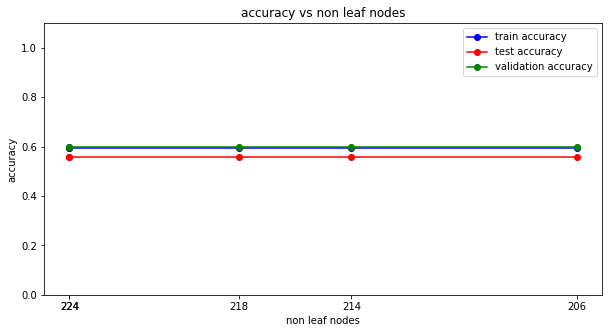

In [135]:
post_pruning(dtree_1h.root, 15)

Initial validation accuracy: 0.6183908045977011
Validation accuracy is 0.6206896551724138. node with id:9341 is now a leaf node. unvisited_non_leaf_nodes:780
Validation accuracy is 0.6218390804597701. node with id:25111 is now a leaf node. unvisited_non_leaf_nodes:765
Validation accuracy is 0.6218390804597701. node with id:8247 is now a leaf node. unvisited_non_leaf_nodes:764
Validation accuracy is 0.6218390804597701. node with id:6013 is now a leaf node. unvisited_non_leaf_nodes:762
Validation accuracy is 0.6218390804597701. node with id:24484 is now a leaf node. unvisited_non_leaf_nodes:753
Validation accuracy is 0.6218390804597701. node with id:23006 is now a leaf node. unvisited_non_leaf_nodes:749
Final Training accuracy:  0.6191388782419829
Final Validation accuracy:  0.6218390804597701
Final Testing accuracy:  0.578076525336091


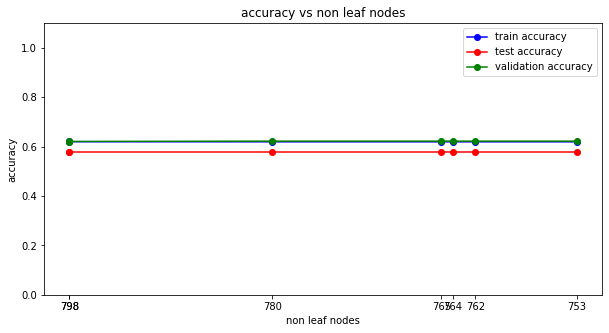

In [136]:
post_pruning(dtree_1h.root, 25)

Initial validation accuracy: 0.603448275862069
Validation accuracy is 0.6114942528735632. node with id:4434 is now a leaf node. unvisited_non_leaf_nodes:2362
Validation accuracy is 0.6183908045977011. node with id:6605 is now a leaf node. unvisited_non_leaf_nodes:2356
Validation accuracy is 0.6241379310344828. node with id:22999 is now a leaf node. unvisited_non_leaf_nodes:2331
Validation accuracy is 0.6275862068965518. node with id:16265 is now a leaf node. unvisited_non_leaf_nodes:2301
Validation accuracy is 0.6298850574712643. node with id:9342 is now a leaf node. unvisited_non_leaf_nodes:2231
Validation accuracy is 0.632183908045977. node with id:11563 is now a leaf node. unvisited_non_leaf_nodes:2148
Validation accuracy is 0.6333333333333333. node with id:3907 is now a leaf node. unvisited_non_leaf_nodes:2143
Validation accuracy is 0.6344827586206897. node with id:7926 is now a leaf node. unvisited_non_leaf_nodes:2137
Validation accuracy is 0.635632183908046. node with id:4151 is 

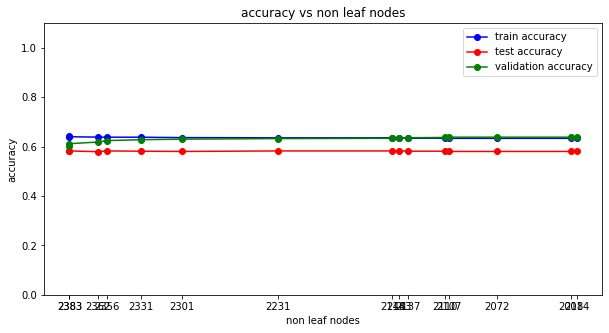

In [137]:
post_pruning(dtree_1h.root, 35)

Initial validation accuracy: 0.6091954022988506
Validation accuracy is 0.6195402298850575. node with id:20741 is now a leaf node. unvisited_non_leaf_nodes:6033
Validation accuracy is 0.6275862068965518. node with id:4426 is now a leaf node. unvisited_non_leaf_nodes:5801
Validation accuracy is 0.635632183908046. node with id:15047 is now a leaf node. unvisited_non_leaf_nodes:5491
Validation accuracy is 0.6413793103448275. node with id:31 is now a leaf node. unvisited_non_leaf_nodes:5390
Validation accuracy is 0.6459770114942529. node with id:25954 is now a leaf node. unvisited_non_leaf_nodes:5377
Validation accuracy is 0.6505747126436782. node with id:12637 is now a leaf node. unvisited_non_leaf_nodes:5054
Validation accuracy is 0.6528735632183909. node with id:7756 is now a leaf node. unvisited_non_leaf_nodes:4950
Validation accuracy is 0.6551724137931034. node with id:1178 is now a leaf node. unvisited_non_leaf_nodes:4921
Validation accuracy is 0.6574712643678161. node with id:11166 i

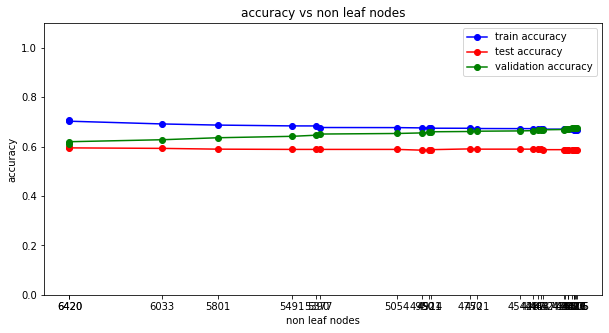

In [138]:
post_pruning(dtree_1h.root, 45)

### Decision tree using scikit learn

In [6]:
X_train,y_train = get_np_array('../Data/train.csv', encoding="onehot")
X_test, y_test = get_np_array("../Data/test.csv", encoding="onehot")
X_val, y_val = get_np_array("../Data/val.csv", encoding="onehot")

##### Keeping criterion as entropy

In [7]:
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train, y_train)

In [8]:
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
print(f"Training accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred)}")

Training accuracy: 1.0
Validation accuracy: 0.6183908045977011


##### (i) Varying the max_depth = {15,25,35,45} and reporting the train and test accuracies

In [9]:
max_depths = [15,25,35,45]
train_accuracy = []
test_accuracy = []
for max_depth in max_depths:
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    clf = clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    y_test_pred = clf.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"max_depth used is {max_depth}")
    print(f"Training accuracy: {train_acc}")
    print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred)}")
    print(f"Testing accuracy: {test_acc}\n")
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

max_depth used is 15
Training accuracy: 0.7129168263702568
Validation accuracy: 0.5850574712643678
Testing accuracy: 0.6070320579110652

max_depth used is 25
Training accuracy: 0.854733614411652
Validation accuracy: 0.6126436781609196
Testing accuracy: 0.6411582213029989

max_depth used is 35
Training accuracy: 0.9442953877603169
Validation accuracy: 0.6091954022988506
Testing accuracy: 0.6535677352637022

max_depth used is 45
Training accuracy: 0.9950172479877347
Validation accuracy: 0.6275862068965518
Testing accuracy: 0.640124095139607



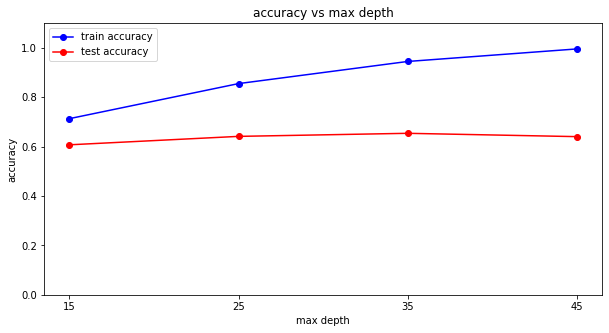

In [11]:
#Plot the train_acc and test_acc for various max depths
plt.figure(figsize=(10,5))
plt.plot(max_depths, train_accuracy, marker='o', markersize=6, color='blue', label='train accuracy')
plt.plot(max_depths, test_accuracy, marker='o', markersize=6, color='red', label='test accuracy')

plt.title('accuracy vs max depth')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.xticks(max_depths)
plt.ylim(0,1.1)
plt.legend()
plt.show()

##### Running the decision tree on the best value of max_depth obtained using validation accuracy

In [12]:
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=45)
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print(f"max_depth used is 45")
print(f"Training accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_test_pred)}\n")

max_depth used is 45
Training accuracy: 0.9951450108598441
Testing accuracy: 0.6349534643226473



##### (ii) Varying the ccp_alpha = {0.001, 0.01, 0.1, 0.2} and reporting the train and test accuracies

In [13]:
ccp_alphas = [0.001, 0.01, 0.1, 0.2]
train_accuracy = []
test_accuracy = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(criterion="entropy", ccp_alpha=ccp_alpha)
    clf = clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    y_test_pred = clf.predict(X_test)
    
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"ccp_alpha used is {ccp_alpha}")
    print(f"Training accuracy: {train_acc}")
    print(f"Validation accuracy: {accuracy_score(y_val, y_val_pred)}")
    print(f"Testing accuracy: {test_acc}\n")
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

ccp_alpha used is 0.001
Training accuracy: 0.6894084579021337
Validation accuracy: 0.632183908045977
Testing accuracy: 0.6628748707342296

ccp_alpha used is 0.01
Training accuracy: 0.5344320940334739
Validation accuracy: 0.5
Testing accuracy: 0.5180972078593589

ccp_alpha used is 0.1
Training accuracy: 0.5033857161108982
Validation accuracy: 0.4735632183908046
Testing accuracy: 0.4963805584281282

ccp_alpha used is 0.2
Training accuracy: 0.5033857161108982
Validation accuracy: 0.4735632183908046
Testing accuracy: 0.4963805584281282



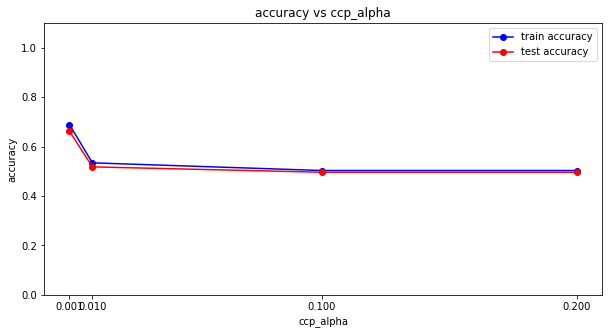

In [14]:
#Plot the train_acc and test_acc for various ccp_alphas
plt.figure(figsize=(10,5))
plt.plot(ccp_alphas, train_accuracy, marker='o', markersize=6, color='blue', label='train accuracy')
plt.plot(ccp_alphas, test_accuracy, marker='o', markersize=6, color='red', label='test accuracy')

plt.title('accuracy vs ccp_alpha')
plt.xlabel('ccp_alpha')
plt.ylabel('accuracy')
plt.xticks(ccp_alphas)
plt.ylim(0,1.1)
plt.legend()
plt.show()

##### Running the decision tree on the best value of ccp_alpha obtained using validation accuracy

In [15]:
clf = tree.DecisionTreeClassifier(criterion="entropy", ccp_alpha=0.001)
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)
print(f"ccp_alpha used is 0.001")
print(f"Training accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test, y_test_pred)}\n")

ccp_alpha used is 0.001
Training accuracy: 0.6894084579021337
Testing accuracy: 0.6628748707342296



#### Random forests

In [17]:
X_train,y_train = get_np_array('../Data/train.csv', encoding="onehot")
X_test, y_test = get_np_array("../Data/test.csv", encoding="onehot")
X_val, y_val = get_np_array("../Data/val.csv", encoding="onehot")

In [24]:
best_oob_score_ = 0
best_n_estimators = None
best_max_features = None
best_min_samples_split = None

for n_estimators in [50, 150, 250, 350]:
    for max_features in [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
        for min_samples_split in [2, 4, 6, 8, 10]:
            print(f"Parameters->(n_estimators={n_estimators}, max_features={max_features}, min_samples_split={min_samples_split})")
            clf = RandomForestClassifier(n_estimators = n_estimators, max_features=max_features, min_samples_split=min_samples_split,criterion = "entropy", oob_score=True)
            clf.fit(X_train, y_train.ravel())
            y_val_pred = clf.predict(X_val)
            print(f"validation accuracy: {accuracy_score(y_val.ravel(), y_val_pred)}")
            print("OOB(out of bag) accuracy: ",clf.oob_score_)
            print("\n")
            
            #update best
            if clf.oob_score_ > best_oob_score_:
                best_oob_score_ = clf.oob_score_
                best_n_estimators = n_estimators
                best_max_features = max_features
                best_min_samples_split = min_samples_split

Parameters->(n_estimators=50, max_features=0.1, min_samples_split=2)
validation accuracy: 0.6850574712643678
OOB(out of bag) accuracy:  0.6804650568544781


Parameters->(n_estimators=50, max_features=0.1, min_samples_split=4)
validation accuracy: 0.6793103448275862
OOB(out of bag) accuracy:  0.6794429538776031


Parameters->(n_estimators=50, max_features=0.1, min_samples_split=6)
validation accuracy: 0.6931034482758621
OOB(out of bag) accuracy:  0.6949022614028363


Parameters->(n_estimators=50, max_features=0.1, min_samples_split=8)
validation accuracy: 0.696551724137931
OOB(out of bag) accuracy:  0.691963715344321


Parameters->(n_estimators=50, max_features=0.1, min_samples_split=10)
validation accuracy: 0.6850574712643678
OOB(out of bag) accuracy:  0.6821259741918998


Parameters->(n_estimators=50, max_features=0.3, min_samples_split=2)
validation accuracy: 0.6885057471264368
OOB(out of bag) accuracy:  0.6927302925769772


Parameters->(n_estimators=50, max_features=0.3, min_samples

validation accuracy: 0.7
OOB(out of bag) accuracy:  0.7168774754056472


Parameters->(n_estimators=150, max_features=0.9, min_samples_split=8)
validation accuracy: 0.7
OOB(out of bag) accuracy:  0.723137856139006


Parameters->(n_estimators=150, max_features=0.9, min_samples_split=10)
validation accuracy: 0.7057471264367816
OOB(out of bag) accuracy:  0.7207103615689281


Parameters->(n_estimators=150, max_features=1.0, min_samples_split=2)
validation accuracy: 0.6988505747126437
OOB(out of bag) accuracy:  0.7173885268940846


Parameters->(n_estimators=150, max_features=1.0, min_samples_split=4)
validation accuracy: 0.6896551724137931
OOB(out of bag) accuracy:  0.7152165580682254


Parameters->(n_estimators=150, max_features=1.0, min_samples_split=6)
validation accuracy: 0.7114942528735633
OOB(out of bag) accuracy:  0.7191772071036157


Parameters->(n_estimators=150, max_features=1.0, min_samples_split=8)
validation accuracy: 0.7114942528735633
OOB(out of bag) accuracy:  0.7184106298709

validation accuracy: 0.6919540229885057
OOB(out of bag) accuracy:  0.7181551041267408


Parameters->(n_estimators=350, max_features=0.7, min_samples_split=4)
validation accuracy: 0.7011494252873564
OOB(out of bag) accuracy:  0.7173885268940846


Parameters->(n_estimators=350, max_features=0.7, min_samples_split=6)
validation accuracy: 0.7
OOB(out of bag) accuracy:  0.7212214130573655


Parameters->(n_estimators=350, max_features=0.7, min_samples_split=8)
validation accuracy: 0.7068965517241379
OOB(out of bag) accuracy:  0.7218602274179123


Parameters->(n_estimators=350, max_features=0.7, min_samples_split=10)
validation accuracy: 0.7011494252873564
OOB(out of bag) accuracy:  0.7209658873131468


Parameters->(n_estimators=350, max_features=0.9, min_samples_split=2)
validation accuracy: 0.6919540229885057
OOB(out of bag) accuracy:  0.7177718155104127


Parameters->(n_estimators=350, max_features=0.9, min_samples_split=4)
validation accuracy: 0.6977011494252874
OOB(out of bag) accuracy: 

#### Running the random forest using optimal hyperparameters obtained based on OOB score

In [25]:
print("Optimal parameters based on OOB score:")
print(f"best_oob_score_:{best_oob_score_}")
print(f"best_n_estimators:{best_n_estimators}")
print(f"best_max_features:{best_max_features}")
print(f"best_min_samples_split:{best_min_samples_split}")

clf = RandomForestClassifier(n_estimators = best_n_estimators, max_features = best_max_features, min_samples_split = best_min_samples_split,criterion = "entropy", oob_score=True)
clf.fit(X_train, y_train.ravel())
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)
print(f"Training accuracy: {accuracy_score(y_train.ravel(), y_train_pred)}")
print(f"Validation accuracy: {accuracy_score(y_val.ravel(), y_val_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test.ravel(), y_test_pred)}")
print("OOB(out of bag) accuracy: ",clf.oob_score_)

Optimal parameters based on OOB score:
best_oob_score_:0.7258208764533026
best_n_estimators:250
best_max_features:1.0
best_min_samples_split:10
Training accuracy: 0.9814743835441421
Validation accuracy: 0.7045977011494253
Testing accuracy: 0.7249224405377456
OOB(out of bag) accuracy:  0.7199437843362719


##### Grid search to find optimal hyperparameters

In [26]:
#making the instance
model = RandomForestClassifier()

#Hyper Parameters Set
params = {
    'n_estimators': [50, 150, 250, 350],
    'max_features': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'min_samples_split': [2, 4, 6, 8, 10],
    'criterion' :['entropy'],
    'oob_score': [True],
    
}

grid = GridSearchCV(estimator=model, param_grid=params, verbose=2)

# Fit the grid search to the data and find best hyperparameters
grid.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END criterion=entropy, max_features=0.1, min_samples_split=2, n_estimators=50, oob_score=True; total time=   0.4s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=2, n_estimators=50, oob_score=True; total time=   0.4s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=2, n_estimators=50, oob_score=True; total time=   0.4s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=2, n_estimators=50, oob_score=True; total time=   0.4s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=2, n_estimators=50, oob_score=True; total time=   0.4s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=2, n_estimators=150, oob_score=True; total time=   1.4s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=2, n_estimators=150, oob_score=True; total time=   1.3s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=2, n_estimators=150, oob_score=True; t

[CV] END criterion=entropy, max_features=0.1, min_samples_split=8, n_estimators=150, oob_score=True; total time=   1.1s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=8, n_estimators=150, oob_score=True; total time=   1.1s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=8, n_estimators=250, oob_score=True; total time=   1.8s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=8, n_estimators=250, oob_score=True; total time=   1.8s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=8, n_estimators=250, oob_score=True; total time=   1.8s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=8, n_estimators=250, oob_score=True; total time=   1.8s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=8, n_estimators=250, oob_score=True; total time=   1.8s
[CV] END criterion=entropy, max_features=0.1, min_samples_split=8, n_estimators=350, oob_score=True; total time=   2.6s
[CV] END criterion=entropy, max_features

[CV] END criterion=entropy, max_features=0.3, min_samples_split=4, n_estimators=350, oob_score=True; total time=   5.4s
[CV] END criterion=entropy, max_features=0.3, min_samples_split=4, n_estimators=350, oob_score=True; total time=   5.4s
[CV] END criterion=entropy, max_features=0.3, min_samples_split=4, n_estimators=350, oob_score=True; total time=   5.5s
[CV] END criterion=entropy, max_features=0.3, min_samples_split=6, n_estimators=50, oob_score=True; total time=   0.8s
[CV] END criterion=entropy, max_features=0.3, min_samples_split=6, n_estimators=50, oob_score=True; total time=   0.8s
[CV] END criterion=entropy, max_features=0.3, min_samples_split=6, n_estimators=50, oob_score=True; total time=   0.8s
[CV] END criterion=entropy, max_features=0.3, min_samples_split=6, n_estimators=50, oob_score=True; total time=   0.8s
[CV] END criterion=entropy, max_features=0.3, min_samples_split=6, n_estimators=50, oob_score=True; total time=   0.8s
[CV] END criterion=entropy, max_features=0.3,

[CV] END criterion=entropy, max_features=0.5, min_samples_split=2, n_estimators=150, oob_score=True; total time=   3.5s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=2, n_estimators=150, oob_score=True; total time=   3.5s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=2, n_estimators=150, oob_score=True; total time=   3.5s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=2, n_estimators=150, oob_score=True; total time=   3.5s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=2, n_estimators=250, oob_score=True; total time=   5.9s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=2, n_estimators=250, oob_score=True; total time=   5.9s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=2, n_estimators=250, oob_score=True; total time=   5.8s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=2, n_estimators=250, oob_score=True; total time=   5.8s
[CV] END criterion=entropy, max_features

[CV] END criterion=entropy, max_features=0.5, min_samples_split=8, n_estimators=350, oob_score=True; total time=   7.8s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=8, n_estimators=350, oob_score=True; total time=   7.8s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=8, n_estimators=350, oob_score=True; total time=   7.6s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=8, n_estimators=350, oob_score=True; total time=   7.7s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=8, n_estimators=350, oob_score=True; total time=   7.8s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=10, n_estimators=50, oob_score=True; total time=   1.1s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=10, n_estimators=50, oob_score=True; total time=   1.1s
[CV] END criterion=entropy, max_features=0.5, min_samples_split=10, n_estimators=50, oob_score=True; total time=   1.1s
[CV] END criterion=entropy, max_features

[CV] END criterion=entropy, max_features=0.7, min_samples_split=6, n_estimators=50, oob_score=True; total time=   1.5s
[CV] END criterion=entropy, max_features=0.7, min_samples_split=6, n_estimators=150, oob_score=True; total time=   4.5s
[CV] END criterion=entropy, max_features=0.7, min_samples_split=6, n_estimators=150, oob_score=True; total time=   4.5s
[CV] END criterion=entropy, max_features=0.7, min_samples_split=6, n_estimators=150, oob_score=True; total time=   4.4s
[CV] END criterion=entropy, max_features=0.7, min_samples_split=6, n_estimators=150, oob_score=True; total time=   4.4s
[CV] END criterion=entropy, max_features=0.7, min_samples_split=6, n_estimators=150, oob_score=True; total time=   4.6s
[CV] END criterion=entropy, max_features=0.7, min_samples_split=6, n_estimators=250, oob_score=True; total time=   7.5s
[CV] END criterion=entropy, max_features=0.7, min_samples_split=6, n_estimators=250, oob_score=True; total time=   7.5s
[CV] END criterion=entropy, max_features=

[CV] END criterion=entropy, max_features=0.9, min_samples_split=2, n_estimators=250, oob_score=True; total time=   9.4s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=2, n_estimators=250, oob_score=True; total time=   9.6s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=2, n_estimators=350, oob_score=True; total time=  13.3s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=2, n_estimators=350, oob_score=True; total time=  13.5s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=2, n_estimators=350, oob_score=True; total time=  13.2s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=2, n_estimators=350, oob_score=True; total time=  13.1s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=2, n_estimators=350, oob_score=True; total time=  13.4s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=4, n_estimators=50, oob_score=True; total time=   1.9s
[CV] END criterion=entropy, max_features=

[CV] END criterion=entropy, max_features=0.9, min_samples_split=10, n_estimators=50, oob_score=True; total time=   1.7s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=10, n_estimators=50, oob_score=True; total time=   1.8s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=10, n_estimators=50, oob_score=True; total time=   1.8s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=10, n_estimators=150, oob_score=True; total time=   5.4s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=10, n_estimators=150, oob_score=True; total time=   5.4s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=10, n_estimators=150, oob_score=True; total time=   5.3s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=10, n_estimators=150, oob_score=True; total time=   5.3s
[CV] END criterion=entropy, max_features=0.9, min_samples_split=10, n_estimators=150, oob_score=True; total time=   5.4s
[CV] END criterion=entropy, max_fea

[CV] END criterion=entropy, max_features=1.0, min_samples_split=6, n_estimators=250, oob_score=True; total time=  10.3s
[CV] END criterion=entropy, max_features=1.0, min_samples_split=6, n_estimators=250, oob_score=True; total time=  10.0s
[CV] END criterion=entropy, max_features=1.0, min_samples_split=6, n_estimators=250, oob_score=True; total time=  10.0s
[CV] END criterion=entropy, max_features=1.0, min_samples_split=6, n_estimators=250, oob_score=True; total time=  10.2s
[CV] END criterion=entropy, max_features=1.0, min_samples_split=6, n_estimators=350, oob_score=True; total time=  14.3s
[CV] END criterion=entropy, max_features=1.0, min_samples_split=6, n_estimators=350, oob_score=True; total time=  14.4s
[CV] END criterion=entropy, max_features=1.0, min_samples_split=6, n_estimators=350, oob_score=True; total time=  14.2s
[CV] END criterion=entropy, max_features=1.0, min_samples_split=6, n_estimators=350, oob_score=True; total time=  14.9s
[CV] END criterion=entropy, max_features

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'],
                         'max_features': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [50, 150, 250, 350],
                         'oob_score': [True]},
             verbose=2)

##### Running the random forest with best hyperparameters obtained using grid search

In [27]:
# Best parameter after tuning 
print("Best parameters: ",grid.best_params_)

# Store the best model for future use 
model = grid.best_estimator_

model.fit(X_train, y_train.ravel())
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
print(f"Training accuracy: {accuracy_score(y_train.ravel(), y_train_pred)}")
print(f"Validation accuracy: {accuracy_score(y_val.ravel(), y_val_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test.ravel(), y_test_pred)}")
print("OOB(out of bag) accuracy: ",model.oob_score_)

Best parameters:  {'criterion': 'entropy', 'max_features': 0.7, 'min_samples_split': 8, 'n_estimators': 350, 'oob_score': True}
Training accuracy: 0.9892679187428134
Validation accuracy: 0.7034482758620689
Testing accuracy: 0.7269906928645294
OOB(out of bag) accuracy:  0.7191772071036157


#### Gradient Boosting Classifier

In [37]:
X_train,y_train = get_np_array('../Data/train.csv', encoding="onehot")
X_test, y_test = get_np_array("../Data/test.csv", encoding="onehot")
X_val, y_val = get_np_array("../Data/val.csv", encoding="onehot")

##### Grid search to find optimal hyperparameters

In [38]:
#making the instance
model = GradientBoostingClassifier()

#Hyper Parameters Set
params = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'learning_rate': [0.1, 0.5, 1.0],
    'min_samples_split': [6, 8, 10],
    'ccp_alpha': [0.0, 0.001, 0.005]
}

grid = GridSearchCV(estimator=model, param_grid=params, verbose=2)

# Fit the grid search to the data and find best hyperparameters
grid.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=6, n_estimators=50; total time=   0.4s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=6, n_estimators=50; total time=   0.4s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=6, n_estimators=50; total time=   0.4s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=6, n_estimators=50; total time=   0.4s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=6, n_estimators=50; total time=   0.4s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.0, learning_

[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=10, n_estimators=250; total time=   2.4s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=10, n_estimators=250; total time=   2.3s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=10, n_estimators=250; total time=   2.3s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=10, n_estimators=250; total time=   2.2s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END ccp_alpha=0.0, learning_rate=0.1, min_samples_split=10, n_estimators=300; total time=   2.7s
[CV] END ccp_alpha=0.0, learning_rate=0.5, min_samples_split=6, n_estimators=50; t

[CV] END ccp_alpha=0.0, learning_rate=0.5, min_samples_split=10, n_estimators=150; total time=   1.5s
[CV] END ccp_alpha=0.0, learning_rate=0.5, min_samples_split=10, n_estimators=150; total time=   1.6s
[CV] END ccp_alpha=0.0, learning_rate=0.5, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END ccp_alpha=0.0, learning_rate=0.5, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END ccp_alpha=0.0, learning_rate=0.5, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END ccp_alpha=0.0, learning_rate=0.5, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END ccp_alpha=0.0, learning_rate=0.5, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END ccp_alpha=0.0, learning_rate=0.5, min_samples_split=10, n_estimators=250; total time=   2.4s
[CV] END ccp_alpha=0.0, learning_rate=0.5, min_samples_split=10, n_estimators=250; total time=   2.4s
[CV] END ccp_alpha=0.0, learning_rate=0.5, min_samples_split=10, n_estimators=250;

[CV] END ccp_alpha=0.0, learning_rate=1.0, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.0, learning_rate=1.0, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.0, learning_rate=1.0, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.0, learning_rate=1.0, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.0, learning_rate=1.0, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.0, learning_rate=1.0, min_samples_split=10, n_estimators=150; total time=   1.4s
[CV] END ccp_alpha=0.0, learning_rate=1.0, min_samples_split=10, n_estimators=150; total time=   1.4s
[CV] END ccp_alpha=0.0, learning_rate=1.0, min_samples_split=10, n_estimators=150; total time=   1.4s
[CV] END ccp_alpha=0.0, learning_rate=1.0, min_samples_split=10, n_estimators=150; total time=   1.4s
[CV] END ccp_alpha=0.0, learning_rate=1.0, min_samples_split=10, n_estimators=150;

[CV] END ccp_alpha=0.001, learning_rate=0.1, min_samples_split=8, n_estimators=300; total time=   2.6s
[CV] END ccp_alpha=0.001, learning_rate=0.1, min_samples_split=8, n_estimators=300; total time=   2.8s
[CV] END ccp_alpha=0.001, learning_rate=0.1, min_samples_split=8, n_estimators=300; total time=   2.7s
[CV] END ccp_alpha=0.001, learning_rate=0.1, min_samples_split=8, n_estimators=300; total time=   2.7s
[CV] END ccp_alpha=0.001, learning_rate=0.1, min_samples_split=8, n_estimators=300; total time=   2.6s
[CV] END ccp_alpha=0.001, learning_rate=0.1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END ccp_alpha=0.001, learning_rate=0.1, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END ccp_alpha=0.001, learning_rate=0.1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END ccp_alpha=0.001, learning_rate=0.1, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END ccp_alpha=0.001, learning_rate=0.1, min_samples_split=10, n_esti

[CV] END ccp_alpha=0.001, learning_rate=0.5, min_samples_split=8, n_estimators=200; total time=   1.7s
[CV] END ccp_alpha=0.001, learning_rate=0.5, min_samples_split=8, n_estimators=200; total time=   1.7s
[CV] END ccp_alpha=0.001, learning_rate=0.5, min_samples_split=8, n_estimators=200; total time=   1.8s
[CV] END ccp_alpha=0.001, learning_rate=0.5, min_samples_split=8, n_estimators=200; total time=   1.8s
[CV] END ccp_alpha=0.001, learning_rate=0.5, min_samples_split=8, n_estimators=200; total time=   1.8s
[CV] END ccp_alpha=0.001, learning_rate=0.5, min_samples_split=8, n_estimators=250; total time=   2.2s
[CV] END ccp_alpha=0.001, learning_rate=0.5, min_samples_split=8, n_estimators=250; total time=   2.2s
[CV] END ccp_alpha=0.001, learning_rate=0.5, min_samples_split=8, n_estimators=250; total time=   2.2s
[CV] END ccp_alpha=0.001, learning_rate=0.5, min_samples_split=8, n_estimators=250; total time=   2.2s
[CV] END ccp_alpha=0.001, learning_rate=0.5, min_samples_split=8, n_estim

[CV] END ccp_alpha=0.001, learning_rate=1.0, min_samples_split=8, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.001, learning_rate=1.0, min_samples_split=8, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.001, learning_rate=1.0, min_samples_split=8, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.001, learning_rate=1.0, min_samples_split=8, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.001, learning_rate=1.0, min_samples_split=8, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.001, learning_rate=1.0, min_samples_split=8, n_estimators=150; total time=   1.3s
[CV] END ccp_alpha=0.001, learning_rate=1.0, min_samples_split=8, n_estimators=150; total time=   1.3s
[CV] END ccp_alpha=0.001, learning_rate=1.0, min_samples_split=8, n_estimators=150; total time=   1.3s
[CV] END ccp_alpha=0.001, learning_rate=1.0, min_samples_split=8, n_estimators=150; total time=   1.3s
[CV] END ccp_alpha=0.001, learning_rate=1.0, min_samples_split=8, n_estim

[CV] END ccp_alpha=0.005, learning_rate=0.1, min_samples_split=6, n_estimators=300; total time=   3.0s
[CV] END ccp_alpha=0.005, learning_rate=0.1, min_samples_split=6, n_estimators=300; total time=   2.9s
[CV] END ccp_alpha=0.005, learning_rate=0.1, min_samples_split=6, n_estimators=300; total time=   2.8s
[CV] END ccp_alpha=0.005, learning_rate=0.1, min_samples_split=6, n_estimators=300; total time=   2.8s
[CV] END ccp_alpha=0.005, learning_rate=0.1, min_samples_split=6, n_estimators=300; total time=   2.7s
[CV] END ccp_alpha=0.005, learning_rate=0.1, min_samples_split=8, n_estimators=50; total time=   0.5s
[CV] END ccp_alpha=0.005, learning_rate=0.1, min_samples_split=8, n_estimators=50; total time=   0.5s
[CV] END ccp_alpha=0.005, learning_rate=0.1, min_samples_split=8, n_estimators=50; total time=   0.5s
[CV] END ccp_alpha=0.005, learning_rate=0.1, min_samples_split=8, n_estimators=50; total time=   0.5s
[CV] END ccp_alpha=0.005, learning_rate=0.1, min_samples_split=8, n_estimator

[CV] END ccp_alpha=0.005, learning_rate=0.5, min_samples_split=6, n_estimators=200; total time=   1.7s
[CV] END ccp_alpha=0.005, learning_rate=0.5, min_samples_split=6, n_estimators=200; total time=   2.0s
[CV] END ccp_alpha=0.005, learning_rate=0.5, min_samples_split=6, n_estimators=200; total time=   1.8s
[CV] END ccp_alpha=0.005, learning_rate=0.5, min_samples_split=6, n_estimators=200; total time=   1.8s
[CV] END ccp_alpha=0.005, learning_rate=0.5, min_samples_split=6, n_estimators=200; total time=   1.7s
[CV] END ccp_alpha=0.005, learning_rate=0.5, min_samples_split=6, n_estimators=250; total time=   2.2s
[CV] END ccp_alpha=0.005, learning_rate=0.5, min_samples_split=6, n_estimators=250; total time=   2.2s
[CV] END ccp_alpha=0.005, learning_rate=0.5, min_samples_split=6, n_estimators=250; total time=   2.2s
[CV] END ccp_alpha=0.005, learning_rate=0.5, min_samples_split=6, n_estimators=250; total time=   2.2s
[CV] END ccp_alpha=0.005, learning_rate=0.5, min_samples_split=6, n_estim

[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=6, n_estimators=100; total time=   0.9s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=6, n_estimators=150; total time=   1.3s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=6, n_estimators=150; total time=   1.3s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=6, n_estimators=150; total time=   1.3s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=6, n_estimators=150; total time=   1.3s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=6, n_estim

[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=10, n_estimators=300; total time=   2.6s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=10, n_estimators=300; total time=   2.6s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=10, n_estimators=300; total time=   2.6s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=10, n_estimators=300; total time=   2.6s
[CV] END ccp_alpha=0.005, learning_rate=1.0, min_samples_split=10, n_estimators=300; total time=   2.6s


GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'ccp_alpha': [0.0, 0.001, 0.005],
                         'learning_rate': [0.1, 0.5, 1.0],
                         'min_samples_split': [6, 8, 10],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             verbose=2)

##### Running the Gradient boosting classifier with best hyperparameters obtained using grid search

In [39]:
# Best parameter after tuning 
print("Best parameters: ",grid.best_params_)

# Store the best model for future use 
model = grid.best_estimator_

model.fit(X_train, y_train.ravel())
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
print(f"Training accuracy: {accuracy_score(y_train.ravel(), y_train_pred)}")
print(f"Validation accuracy: {accuracy_score(y_val.ravel(), y_val_pred)}")
print(f"Testing accuracy: {accuracy_score(y_test.ravel(), y_test_pred)}")

Best parameters:  {'ccp_alpha': 0.0, 'learning_rate': 0.5, 'min_samples_split': 10, 'n_estimators': 100}
Training accuracy: 0.7926408585665006
Validation accuracy: 0.732183908045977
Testing accuracy: 0.7228541882109617
